In [1]:
import pandas as pd
import csv
import os
import numpy as np
import datetime
from xlsxwriter.workbook import Workbook
from xlsxwriter import Workbook
import time
from scipy import integrate, stats
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import preprocessing
import re

# %matplotlib inline

In [2]:
Working_dir = os.getcwd()
Data_dir = os.path.join(Working_dir, 'Raw data')
Data_prep_dir = os.path.join(Working_dir, 'Preprocessed data')
Output_dir = os.path.join(Working_dir, 'Analysis')

In [55]:
nodes_file_names = ['May2018_idle.csv', 'June2018_idle.csv', 'July2018_idle.csv', \
                    'September2018.csv', 'October2018.csv', 'November2018.csv', \
                    'December2018.csv' , 'January2019.csv']

In [56]:
nodes_df_names = [item.split('.')[0] for item in nodes_file_names]

## Preprocessing - all the months

In [16]:
for file_name in nodes_file_names:
    node_df = pd.read_csv( os.path.join( Data_dir, file_name), delimiter=";", header=0 )
    node_df.dcenergy = node_df.dcenergy.apply(lambda x: float(x.replace(",", ".")) )

    node_df["timestamp_py"] = node_df["tempo"].\
        apply(lambda x: datetime.datetime.strptime(x, '%a %d %b %H:%M:%S CEST %Y') if 'CEST' in x \
              else datetime.datetime.strptime(x, '%a %d %b %H:%M:%S CET %Y'))
        
    node_df.iloc[:,3:-1] = node_df.iloc[:, 3:-1].\
        apply(lambda y: y.\
                apply(lambda x: \
                      float(x.replace(",", ".")) if type(x)==str else x ))
    node_df.to_csv(path_or_buf=os.path.join( Data_prep_dir, file_name), sep=';', index=False)

## Energy analysis - calculations

In [5]:
def forth_integral(node, time, power=['cpu', 'mem', 'sys']):
    power_kw = node[power + '_power'][1:].values/1000.0
    return(np.dot(power_kw, time))

In [6]:
def error_percentage(a, b):
    if a > 0.:
        return(abs(a-b) / a * 100.)
    else: 
        return(abs(a-b) / b * 100.)

In [7]:
def percentage(a, b):
    return(a / b * 100.)

In [ ]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    
    nodes_df_dict[df_name] = pd.DataFrame(columns = list(node_df.nodename.unique()), \
                                          index = ['total_dcenergy', 'sys_energy', \
                                                   'cpu_energy', 'mem_energy', 'other_energy', \
                                                   'cpu_en_percent', 'mem_en_percent', \
                                                   'other_en_percent', 'sys_util', 'mem_util', 'cpu_util', \
                                                   'other_util','sys_power_max', 'cpu_power_max',\
                                                   'mem_power_max', 'dcenergy_error_percent'], data=0)
    
    for node in nodes_df_dict[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        time_difference = (one_node_df["timestamp_measure"][1:].values -\
            one_node_df["timestamp_measure"][:-1].values)/3600.0

        for util_type in ['cpu', 'mem', 'sys']:
            # Integrate system power over time
            nodes_df_dict[df_name].loc[util_type + '_energy', node] = forth_integral(node=one_node_df, \
                                                                                     time=time_difference, \
                                                                                     power=util_type)
            # Find max power utilization by CPU, mem and system
            max_val = one_node_df.loc[:,util_type + '_power'].max() 
            if nodes_df_dict[df_name].loc[util_type + '_power_max', node] < max_val:
                nodes_df_dict[df_name].loc[util_type + '_power_max', node] = max_val
        
        # Energy meter rise
        nodes_df_dict[df_name].loc["total_dcenergy", node] = \
            node_df[node_df.nodename == node]["dcenergy"].values[-1] - \
            node_df[node_df.nodename == node]["dcenergy"].values[0]
    
        # Integral of sys power vs dcenergy meter error in %
        nodes_df_dict[df_name].loc["dcenergy_error_percent", node] = \
            error_percentage(nodes_df_dict[df_name].loc["total_dcenergy",node], \
                             nodes_df_dict[df_name].loc["sys_energy", node])
            
    # Energy used for purposes other than CPU and memory
    nodes_df_dict[df_name].loc["other_energy", :] = nodes_df_dict[df_name].loc["sys_energy", :] - \
        nodes_df_dict[df_name].loc["cpu_energy", :] - nodes_df_dict[df_name].loc["mem_energy", :]
        
    # Energy portion used for CPU and memory in overall the system energy consumption
    for util_type in ['cpu', 'mem', 'other']:
        nodes_df_dict[df_name].loc[util_type + '_en_percent', :] = \
            percentage(nodes_df_dict[df_name].loc[util_type + '_energy',:], nodes_df_dict[df_name].loc["sys_energy", :])
    
    nodes_df_dict[df_name].to_csv( path_or_buf=os.path.join( Output_dir, 'nodes_stats_' + file_name), sep=';' )    
    print(df_name)

In [108]:
node_df = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_May2018_idle.csv'), delimiter=";", header=0, index_col=0 )
node_names = node_df.columns.values

In [128]:
nodes_summary_df = pd.DataFrame(columns = node_names, \
                                          index = ['total_dcenergy', 'sys_energy', \
                                                   'cpu_energy', 'mem_energy', 'other_energy', \
                                                   'cpu_en_percent', 'mem_en_percent', \
                                                   'other_en_percent', 'sys_util', 'mem_util', 'cpu_util', \
                                                   'other_util','sys_power_max', 'cpu_power_max',\
                                                   'mem_power_max', 'dcenergy_error_percent', \
                                                   'present_in_months'], data=0)

nodes_summary_no_drop_df = nodes_summary_df.copy()

for file_name in nodes_file_names:
    node_df = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_' + file_name), delimiter=";", header=0, index_col=0 )
    
    to_drop_ix = np.unique(np.append(\
                                     np.where(node_df.loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(node_df.loc["dcenergy_error_percent", :] > 5.)[0]))
    to_drop = node_df.iloc[:,to_drop_ix].columns.values
    node_df.loc['present_in_months', :] = 1
    
    nodes_summary_no_drop_df = node_df.replace([np.inf, -np.inf, np.nan], 0).add(nodes_summary_no_drop_df).fillna(node_df)
    
    node_df.loc[:,to_drop] = 0
    nodes_summary_df = node_df.add(nodes_summary_df).fillna(node_df)
    
nodes_summary_df.iloc[5:-1,:] = nodes_summary_df.iloc[5:-1,:] / nodes_summary_df.loc['present_in_months', :]
nodes_summary_no_drop_df.iloc[5:-1,:] = nodes_summary_no_drop_df.iloc[5:-1,:] / \
                                            nodes_summary_no_drop_df.loc['present_in_months', :]
nodes_summary_no_drop_df.loc['total_dcenergy', :] = 0

In [130]:
nodes_summary_df.loc[:,'total_all_nodes'] = nodes_summary_df.iloc[:5,:].sum(axis=1)
nodes_summary_df.loc[:,'total_all_nodes'].fillna(0, inplace=True)

nodes_summary_df.loc[:,'avg_all_nodes'] = nodes_summary_df.iloc[5:-1,:].mean(axis=1)
nodes_summary_df.loc['other_en_percent','avg_all_nodes'] = 100.0 - nodes_summary_df.iloc[5:7,-1].sum()
nodes_summary_df.loc[:,'avg_all_nodes'].fillna(0, inplace=True)


nodes_summary_no_drop_df.loc[:,'total_all_nodes'] = nodes_summary_no_drop_df.iloc[:5,:].sum(axis=1)
nodes_summary_no_drop_df.loc[:,'total_all_nodes'].fillna(0, inplace=True)

nodes_summary_no_drop_df.loc[:,'avg_all_nodes'] = nodes_summary_no_drop_df.iloc[5:-1,:].mean(axis=1)
nodes_summary_no_drop_df.loc['other_en_percent','avg_all_nodes'] = \
    100.0 - nodes_summary_no_drop_df.iloc[5:7,-1].sum()
nodes_summary_no_drop_df.loc[:,'avg_all_nodes'].fillna(0, inplace=True)

nodes_summary_df.to_csv( path_or_buf=os.path.join( Output_dir, 'nodes_summary_all_months.csv'), sep=';') 
nodes_summary_no_drop_df.to_csv( path_or_buf=os.path.join( Output_dir, 'nodes_summary_all_months_no_drop.csv'), sep=';') 

In [131]:
nodes_summary_df

,cresco6x001,cresco6x002,cresco6x003,cresco6x004,cresco6x005,cresco6x006,cresco6x007,cresco6x008,cresco6x009,cresco6x010,...,cresco6x209,cresco6x210,cresco6x211,cresco6x212,cresco6x213,cresco6x214,cresco6x215,cresco6x216,total_all_nodes,avg_all_nodes
total_dcenergy,668.412340,698.623150,920.954780,766.082900,830.867090,1007.755650,681.564050,996.702980,633.623990,844.767620,...,1011.415880,792.023120,820.809540,992.390400,894.326160,951.053620,553.292050,596.119660,189462.273940,0.000000
sys_energy,678.912519,700.473342,923.588981,770.110575,841.670575,1013.499164,686.363511,997.893178,635.902667,852.345058,...,1010.763489,797.629575,826.106725,995.432336,902.749339,955.196519,550.078186,598.920961,189989.099819,0.000000
cpu_energy,503.419681,521.009006,707.945944,580.170517,646.391767,804.719447,538.024294,783.350294,500.871889,675.949342,...,792.743200,619.277750,660.786247,778.960517,686.056336,742.857286,430.811217,460.815581,149444.171739,0.000000
mem_energy,57.619268,54.004561,65.548687,48.166355,68.443056,71.183425,53.513991,63.445231,33.088958,60.003576,...,65.272325,66.905083,65.336423,64.539444,68.428979,68.393183,47.853110,53.303608,13009.245224,0.000000
other_energy,117.873571,125.459775,150.094349,141.773703,126.835752,137.596291,94.825226,151.097653,101.941819,116.392141,...,152.747964,111.446743,99.984055,151.932375,148.264024,143.946051,71.413859,84.801772,27535.682856,0.000000
cpu_en_percent,74.211929,74.426867,76.622813,75.148869,76.628965,79.269897,78.357268,78.350685,78.693497,79.147436,...,78.296726,77.655855,79.710073,78.140199,75.680912,77.603230,78.303699,76.312920,0.000000,78.160886
mem_en_percent,8.451839,7.665488,7.085923,6.220218,8.146963,7.039377,7.804677,6.415415,5.224424,7.098905,...,6.522985,8.377075,7.971364,6.511110,7.669609,7.222935,8.638729,9.071007,0.000000,6.859162
other_en_percent,17.336232,17.907644,16.291264,18.630913,15.224072,13.690726,13.838055,15.233900,16.082080,13.753659,...,15.180289,13.967071,12.318563,15.348691,16.649479,15.173835,13.057573,14.616074,0.000000,14.979951
sys_util,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mem_util,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [132]:
nodes_summary_no_drop_df

,cresco6x001,cresco6x002,cresco6x003,cresco6x004,cresco6x005,cresco6x006,cresco6x007,cresco6x008,cresco6x009,cresco6x010,...,cresco6x209,cresco6x210,cresco6x211,cresco6x212,cresco6x213,cresco6x214,cresco6x215,cresco6x216,total_all_nodes,avg_all_nodes
total_dcenergy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sys_energy,774.644981,817.436689,923.588981,898.073389,916.222039,1013.499164,963.267044,997.893178,1001.345358,999.214233,...,1010.763489,968.257783,963.011086,995.432336,1022.370214,955.196519,757.549633,796.348456,216229.424019,0.000000
cpu_energy,573.713572,607.925239,707.945944,674.793369,704.857322,804.719447,758.988853,783.350294,783.286322,793.106114,...,792.743200,756.145458,771.241028,778.960517,778.147700,742.857286,592.843681,611.247419,169986.527539,0.000000
mem_energy,65.737076,63.263435,65.548687,55.531527,73.695239,71.183425,73.868441,63.445231,53.956934,69.873198,...,65.272325,78.885709,76.500341,64.539444,77.354509,68.393183,65.342414,70.031888,15700.162331,0.000000
other_energy,135.194332,146.248015,150.094349,167.748493,137.669478,137.596291,130.409751,151.097653,164.102102,136.234921,...,152.747964,133.226616,115.269717,151.932375,166.868004,143.946051,99.363539,115.069148,30542.734150,0.000000
cpu_en_percent,74.113867,74.412341,76.622813,74.998458,76.853230,79.269897,78.649732,78.350685,78.146526,79.225191,...,78.296726,77.975623,79.831345,78.140199,75.844052,77.603230,78.252966,76.336728,0.000000,77.371882
mem_en_percent,8.455320,7.696808,7.085923,6.162155,8.009223,7.039377,7.702965,6.415415,5.411724,7.051543,...,6.522985,8.207625,7.994261,6.511110,7.643597,7.222935,8.610311,8.900606,0.000000,6.815884
other_en_percent,17.430813,17.890851,16.291264,18.839387,15.137547,13.690726,13.647303,15.233900,16.441750,13.723266,...,15.180289,13.816752,12.174394,15.348691,16.512351,15.173835,13.136723,14.762666,0.000000,15.812234
sys_util,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mem_util,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Energy analysis

In [8]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name]  = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_' + file_name), \
                                          delimiter=";", header=0, index_col=0 )

### Errors in DC energy meter over months concern the following nodes

In [9]:
dcenergy_error_nodes_dict = {}
dcenergy_all_error_nodes = []
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    dcenergy_error_nodes_dict[df_name] = np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :] > 5.)[0]
    
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    
    for node in nodes_df_dict[df_name].iloc[:, dcenergy_error_nodes_dict[df_name] ].columns.values:
        int_name = int(node.split('x')[-1])
        if not(int_name in dcenergy_all_error_nodes):
            dcenergy_all_error_nodes.append(int_name)

In [10]:
print(list(set(dcenergy_all_error_nodes)))

[1, 2, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 45, 47, 52, 53, 54, 55, 58, 59, 60, 61, 64, 65, 66, 67, 68, 71, 72, 73, 77, 78, 79, 82, 83, 91, 92, 93, 94, 96, 98, 100, 101, 102, 105, 107, 108, 112, 115, 117, 118, 119, 120, 121, 124, 127, 131, 134, 135, 137, 139, 140, 141, 146, 150, 151, 154, 158, 160, 162, 163, 164, 169, 170, 172, 173, 175, 176, 177, 179, 181, 182, 187, 191, 195, 197, 198, 203, 204, 206, 208, 210, 211, 213, 215, 216]


In [ ]:
with open(os.path.join( Output_dir,'dcenergy_error_nodes.txt'), "w") as f:
    f.write(str(list(set(dcenergy_all_error_nodes))))

In [ ]:
with open(os.path.join( Output_dir,'dcenergy_error_nodes.csv'),'w') as f:
    w = csv.writer(f)
    w.writerows(dcenergy_error_nodes_dict.keys(), dcenergy_error_nodes_dict)

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


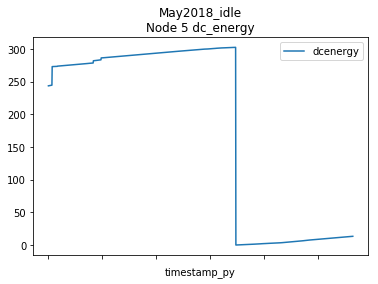

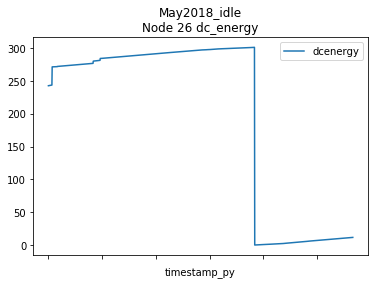

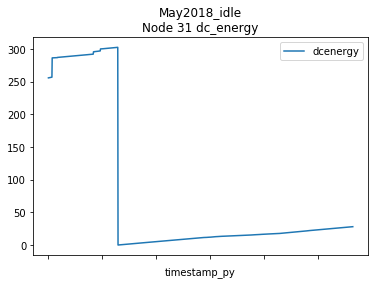

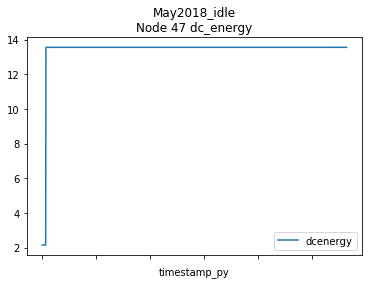

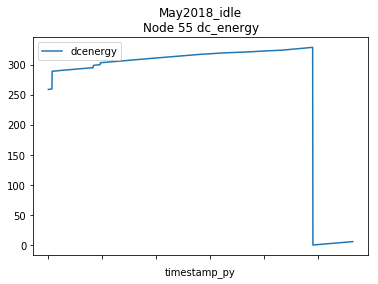

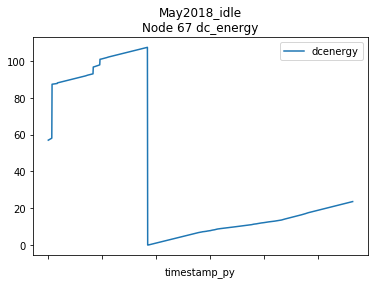

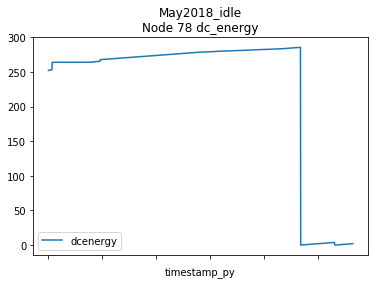

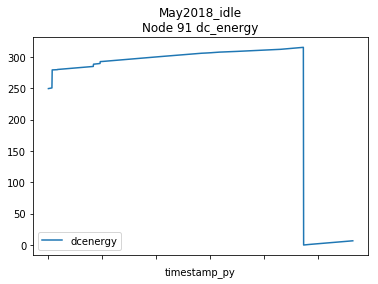

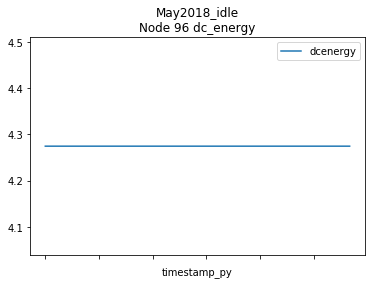

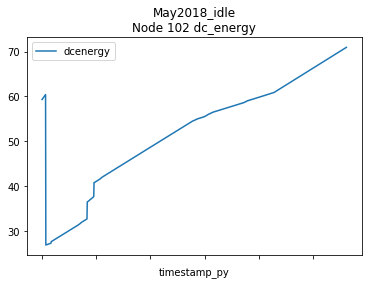

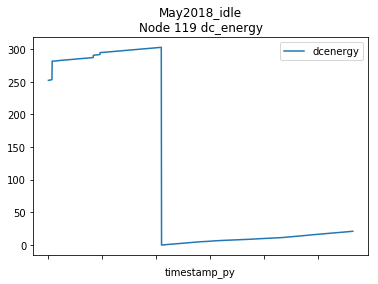

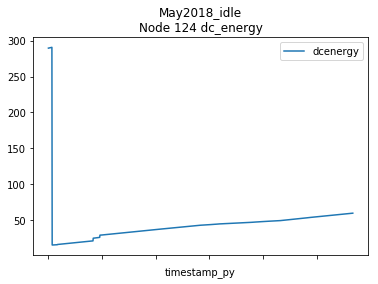

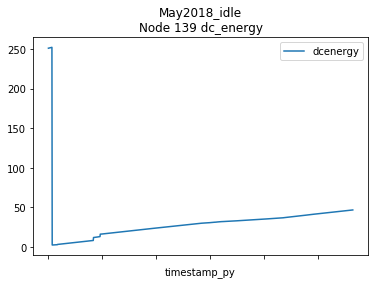

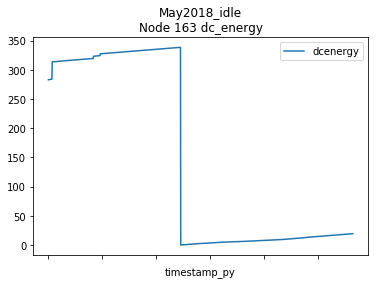

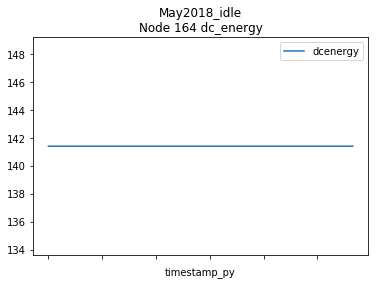

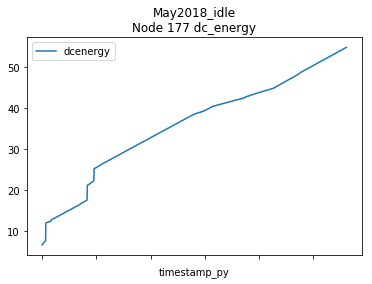

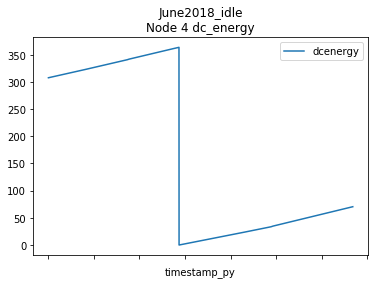

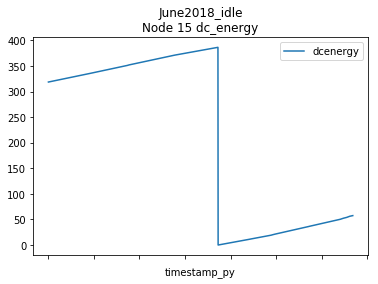

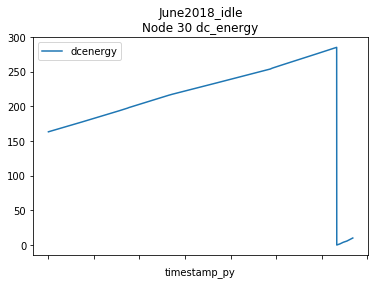

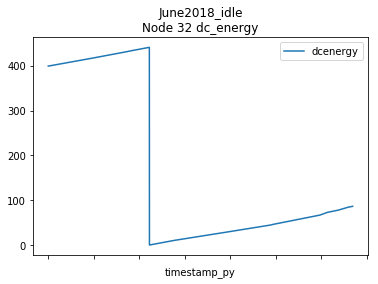

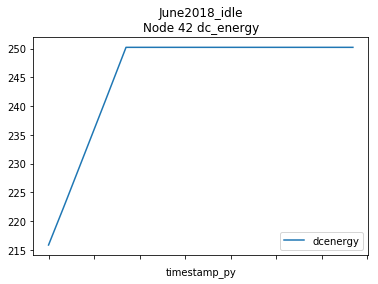

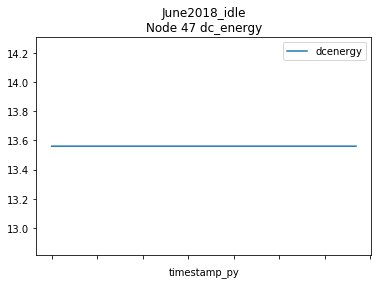

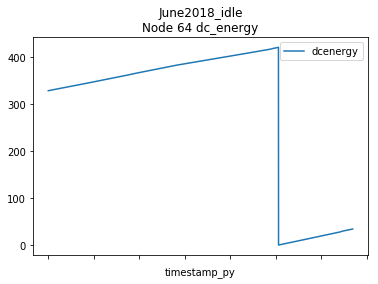

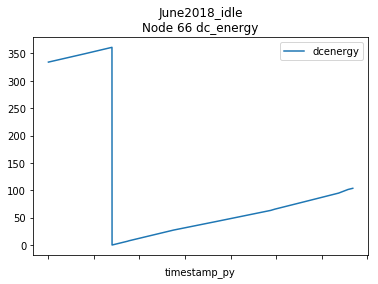

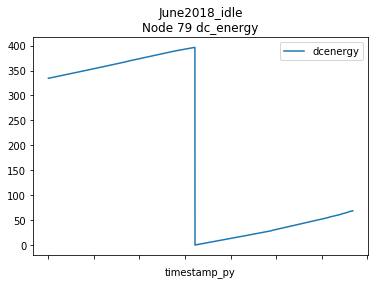

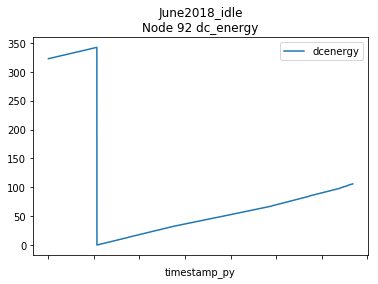

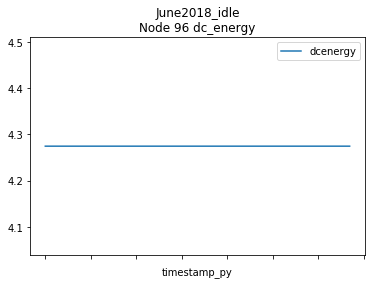

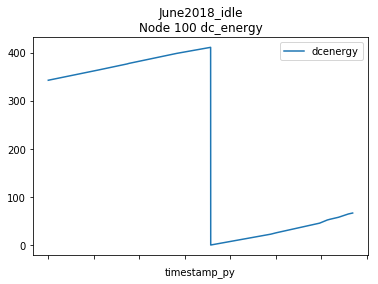

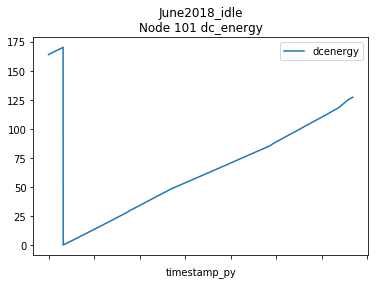

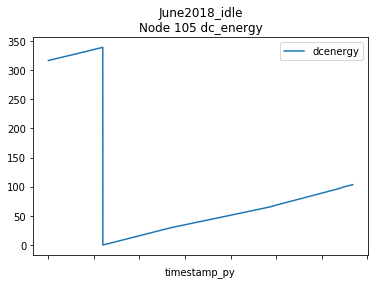

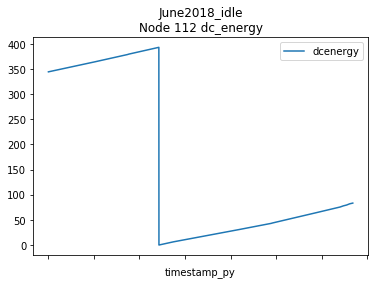

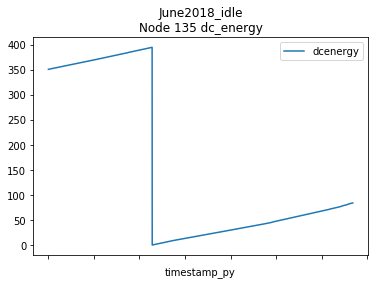

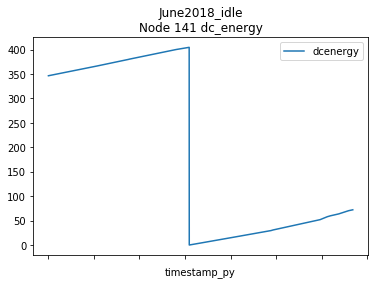

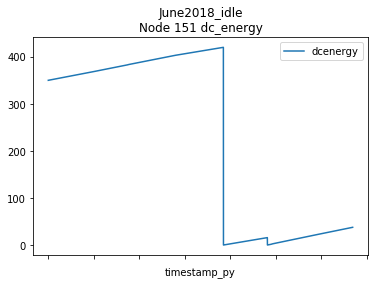

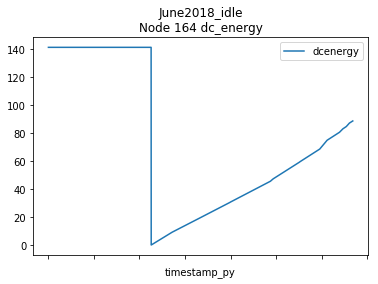

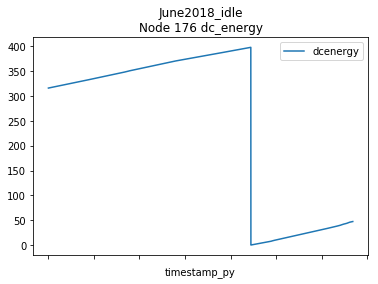

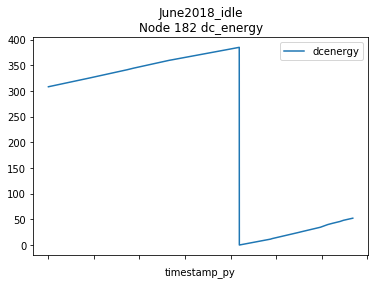

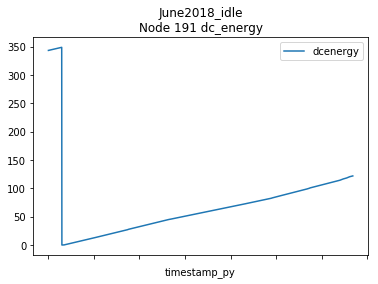

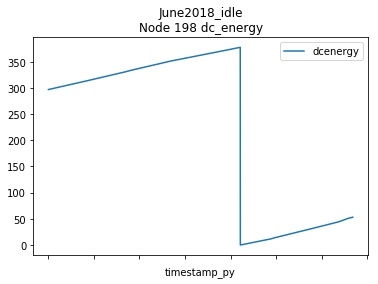

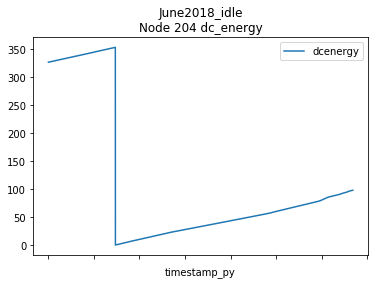

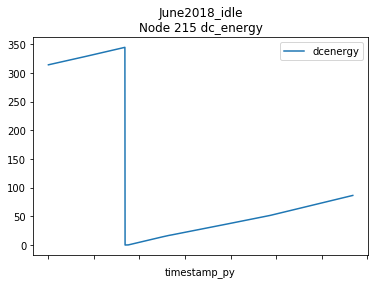

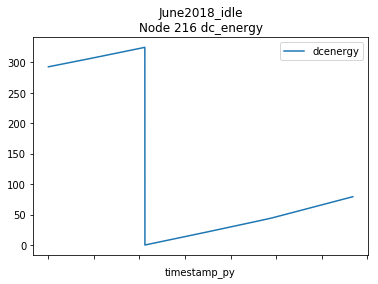

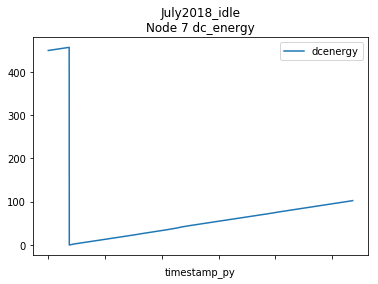

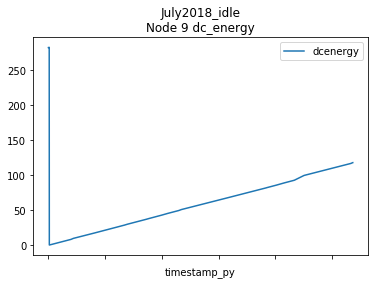

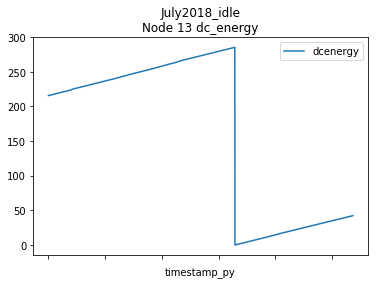

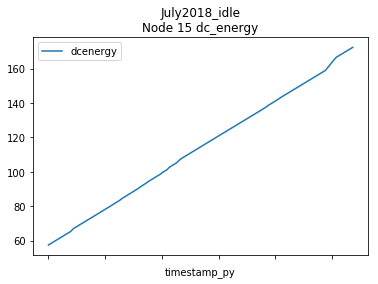

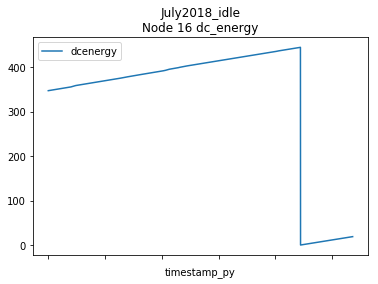

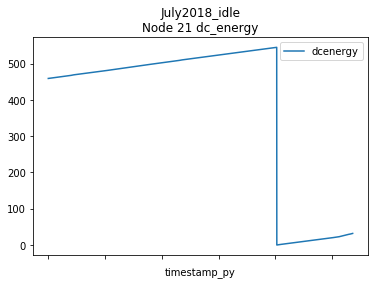

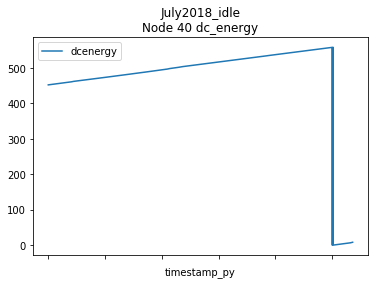

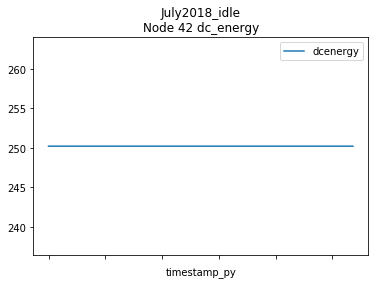

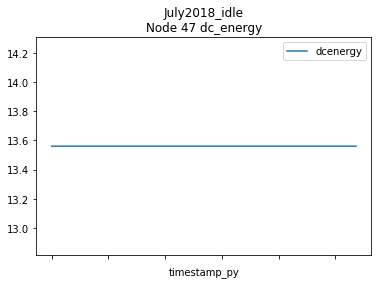

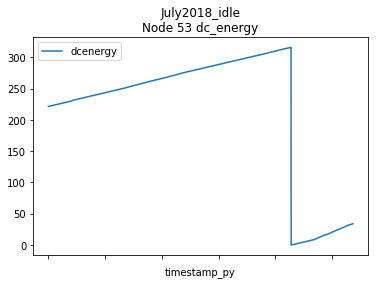

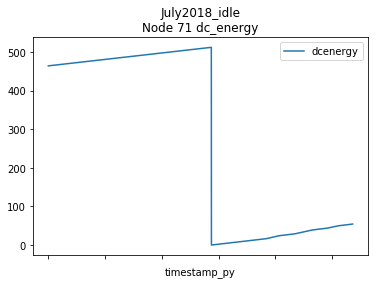

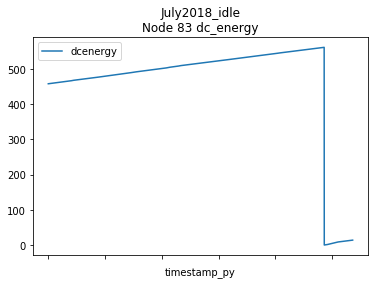

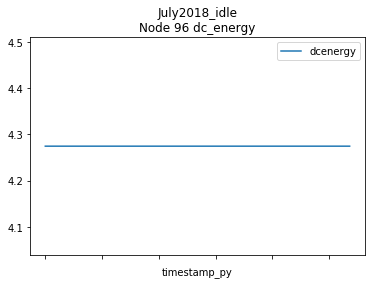

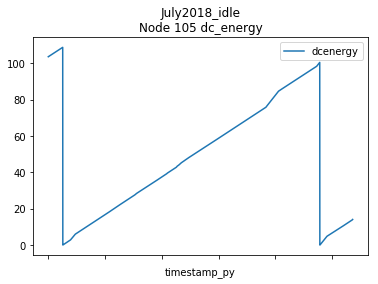

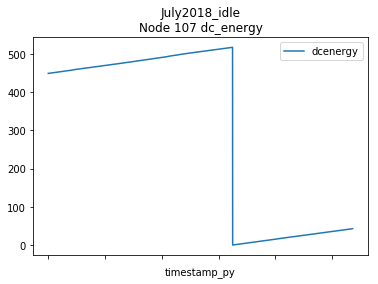

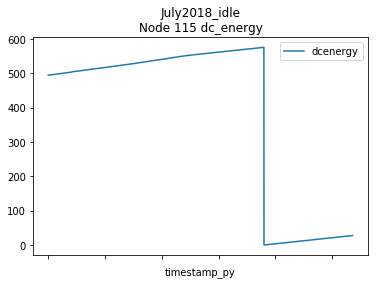

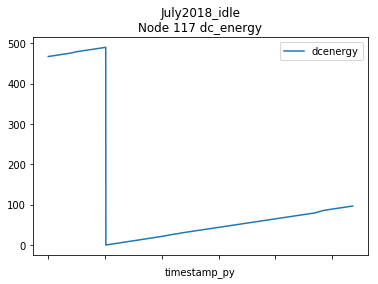

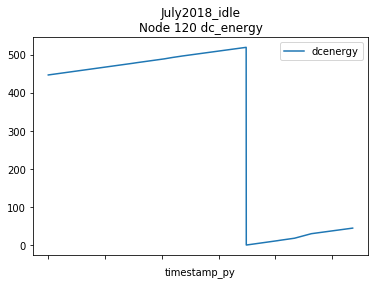

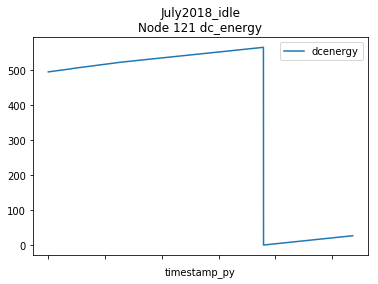

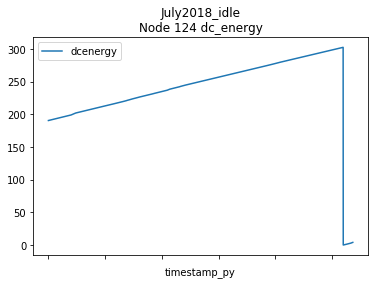

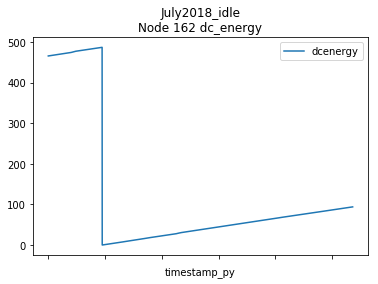

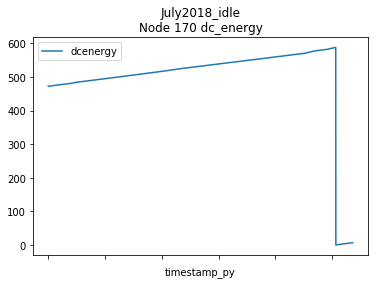

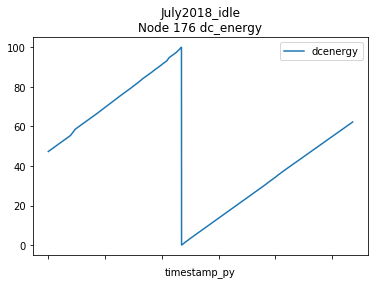

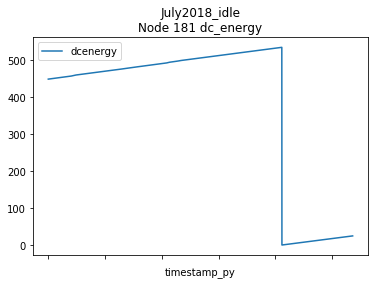

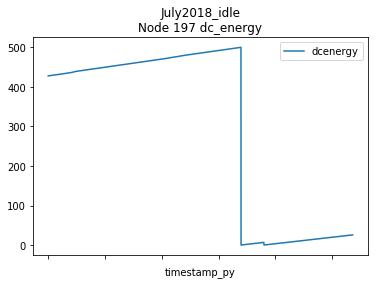

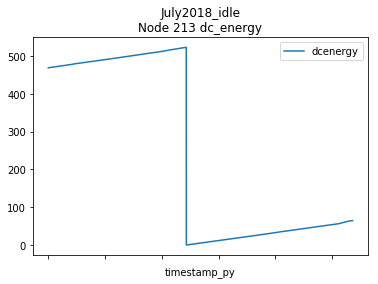

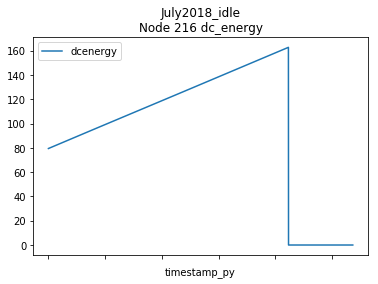

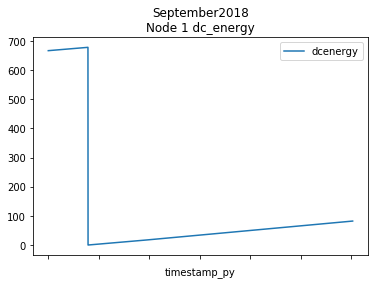

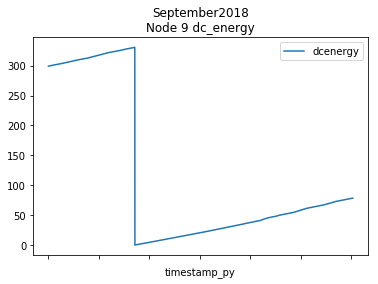

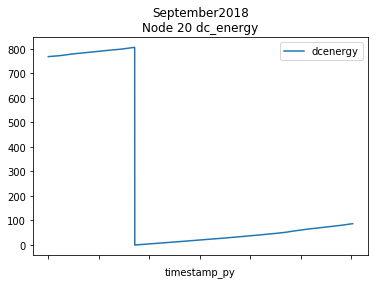

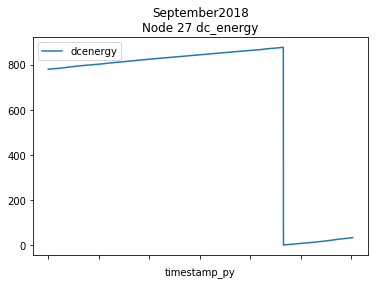

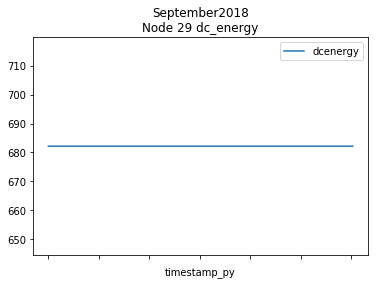

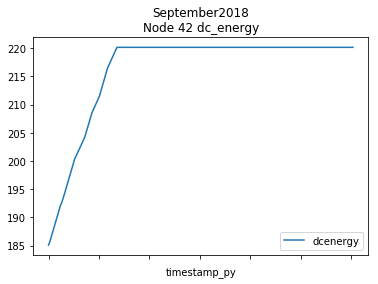

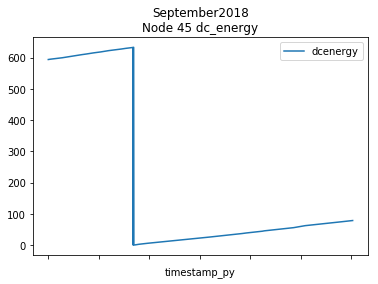

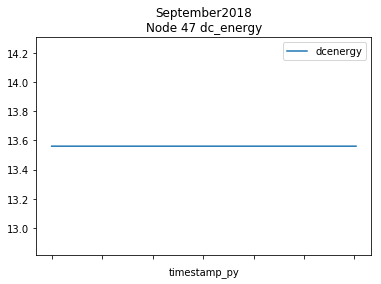

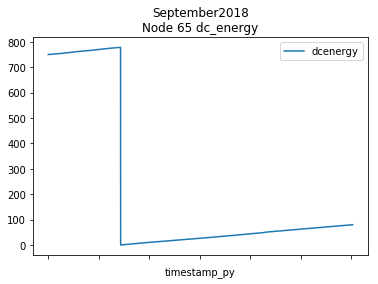

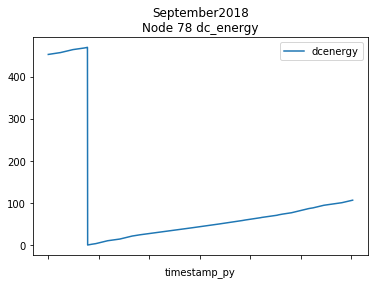

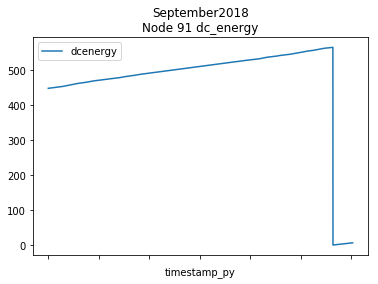

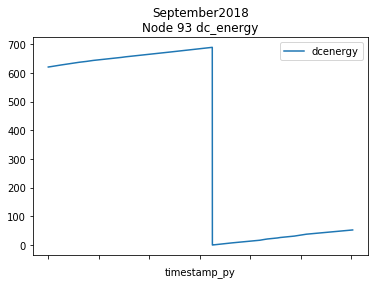

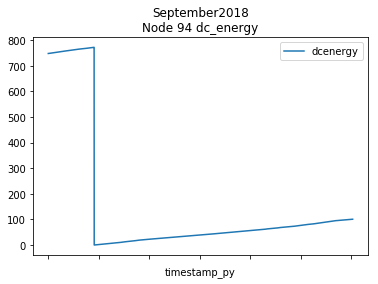

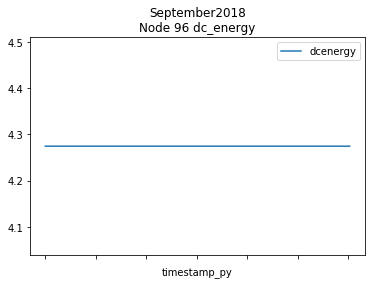

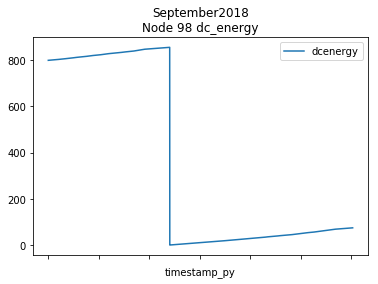

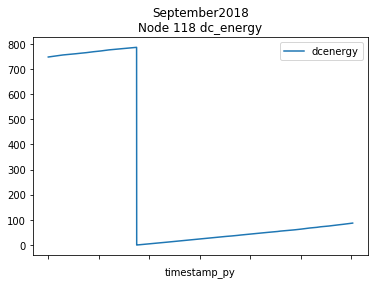

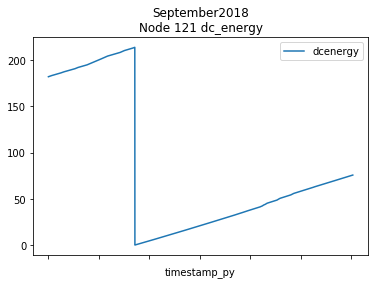

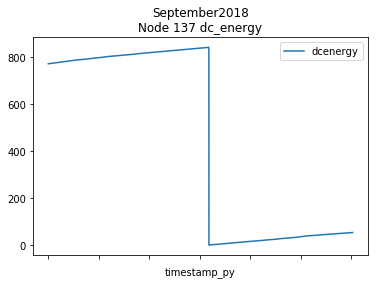

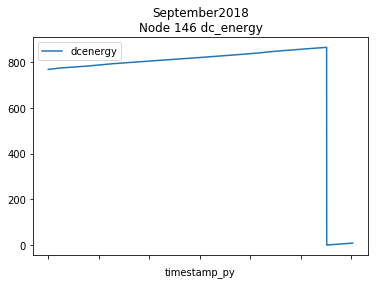

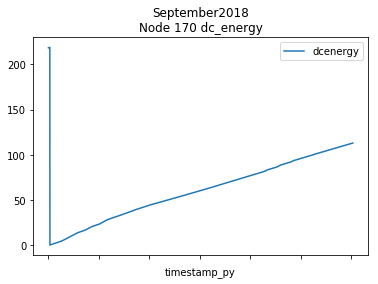

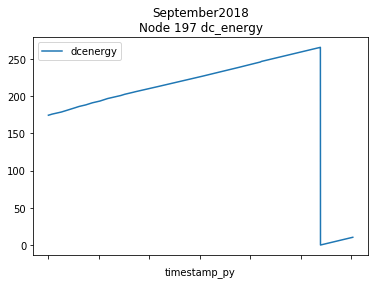

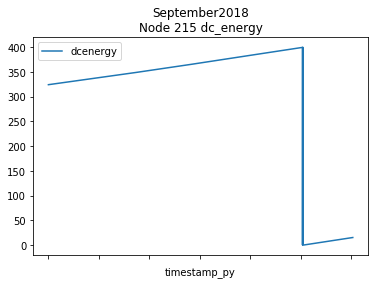

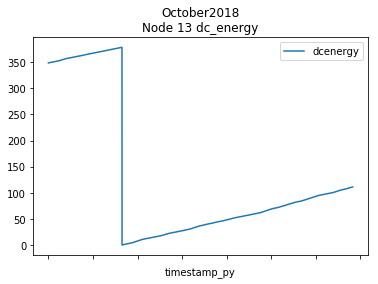

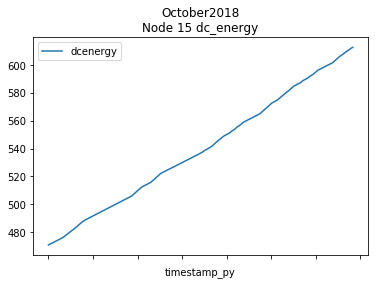

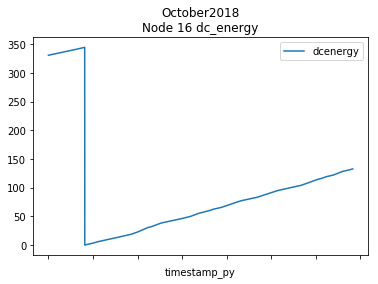

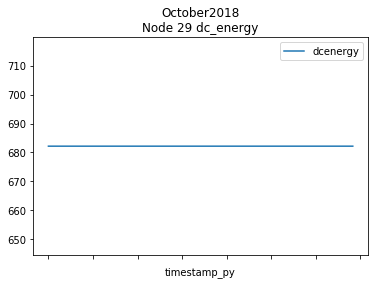

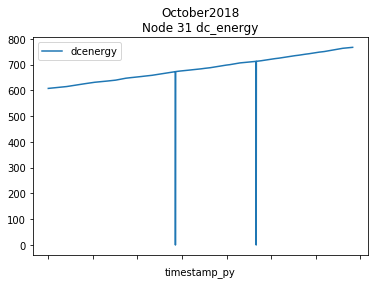

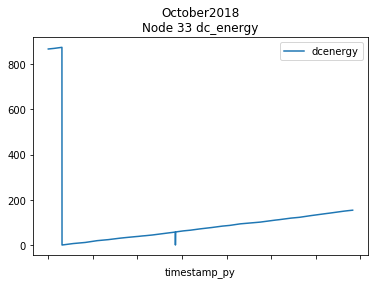

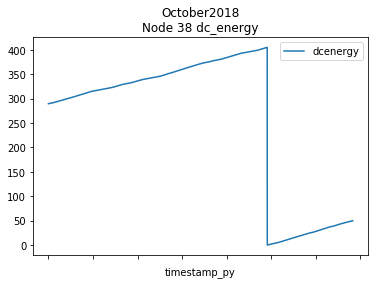

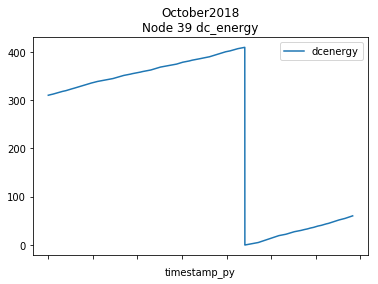

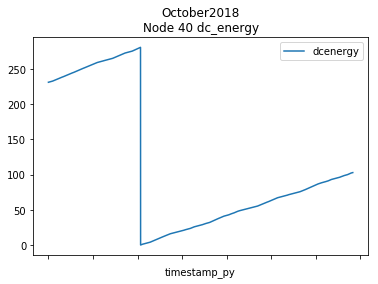

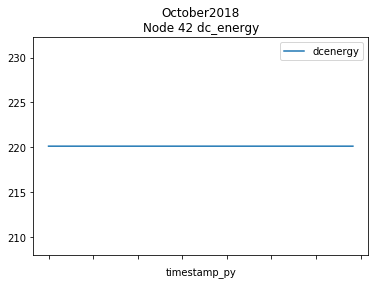

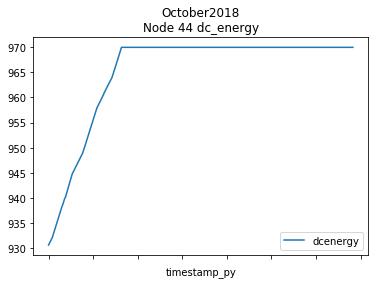

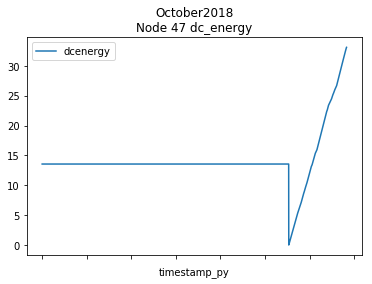

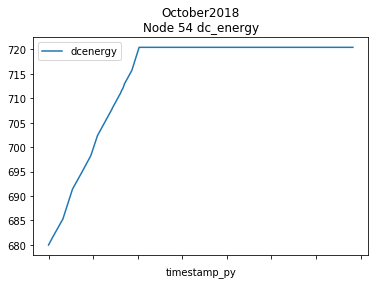

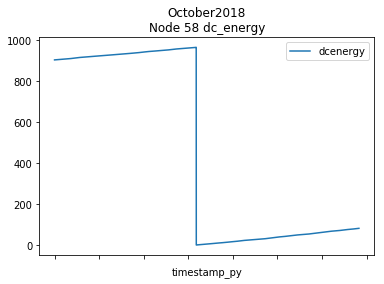

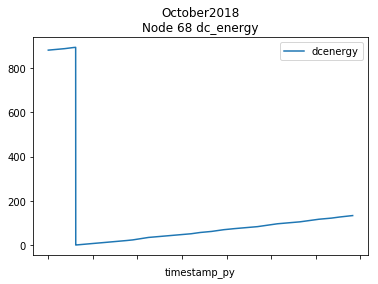

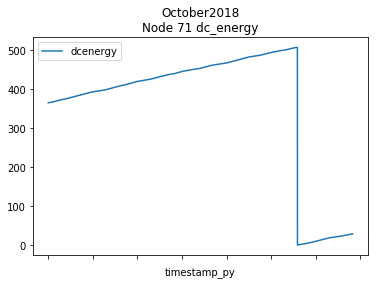

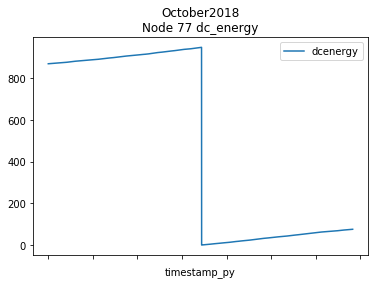

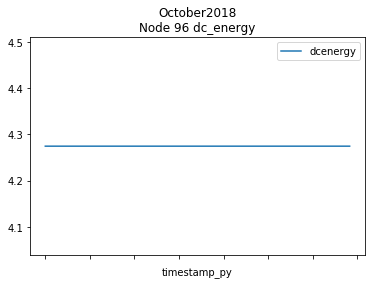

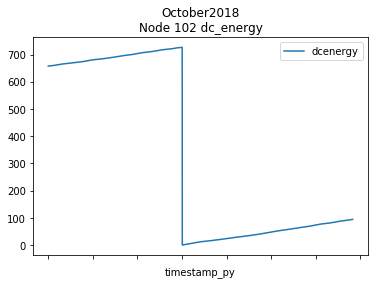

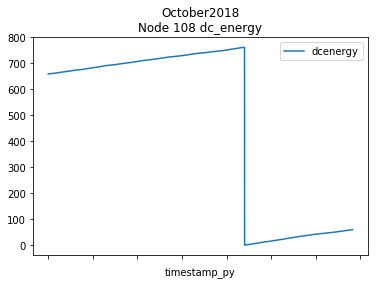

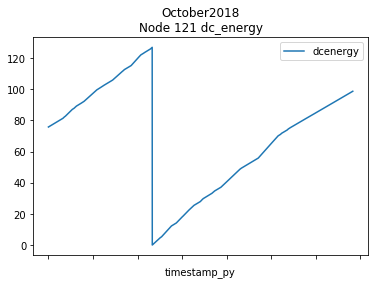

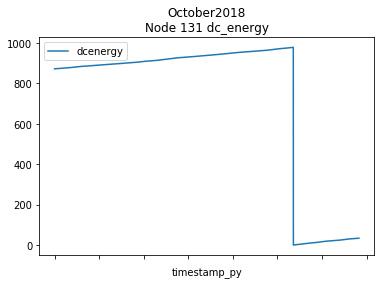

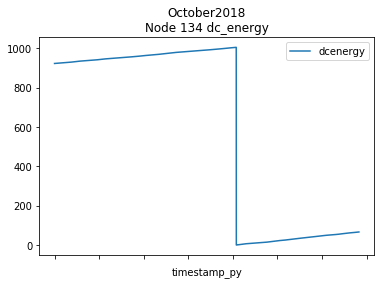

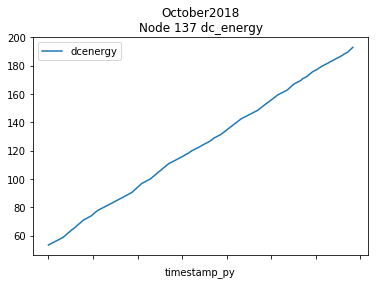

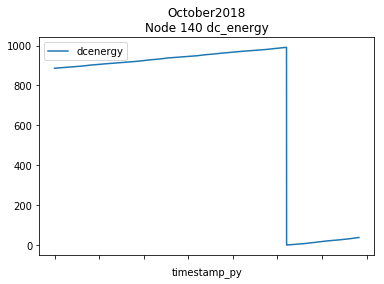

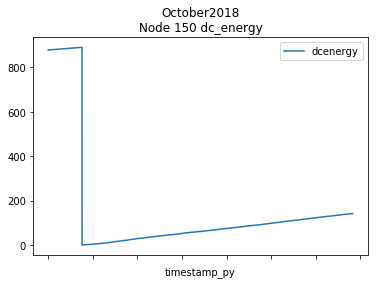

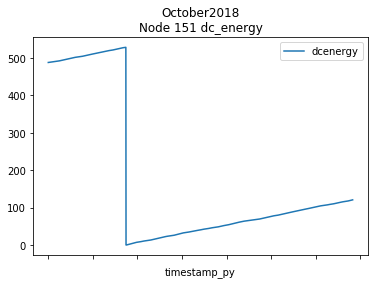

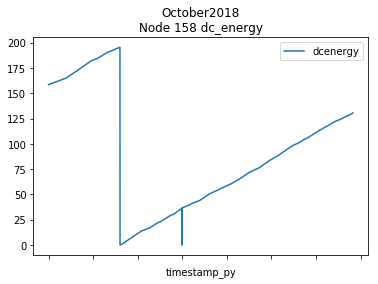

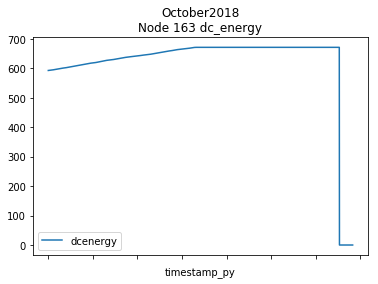

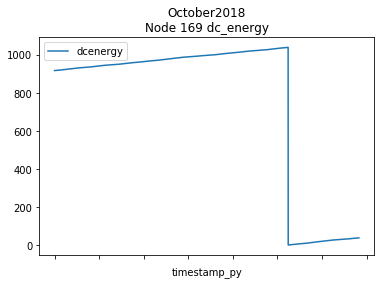

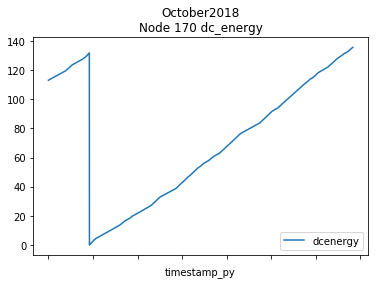

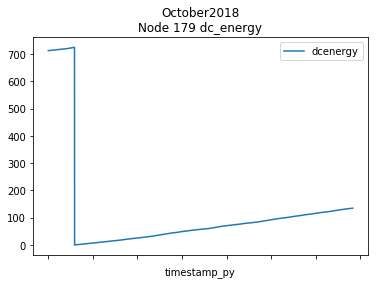

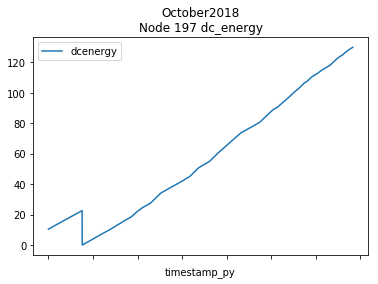

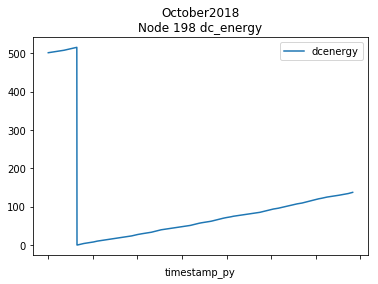

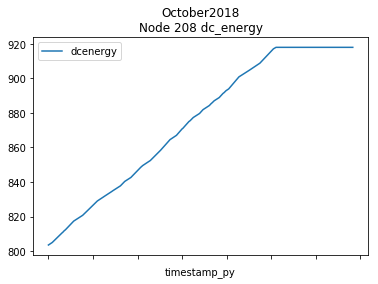

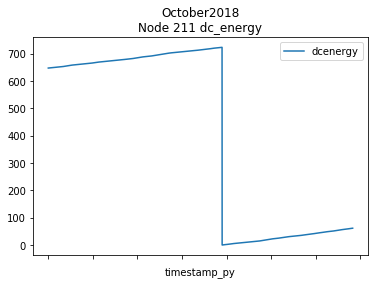

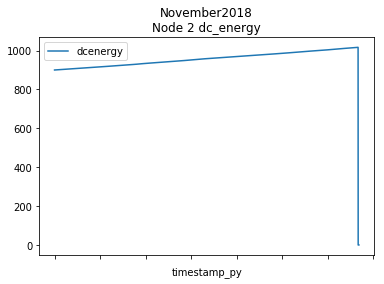

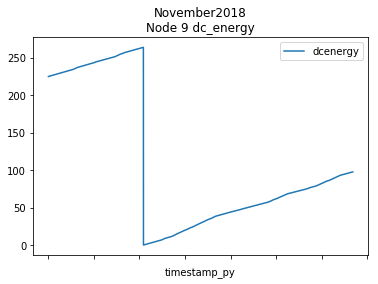

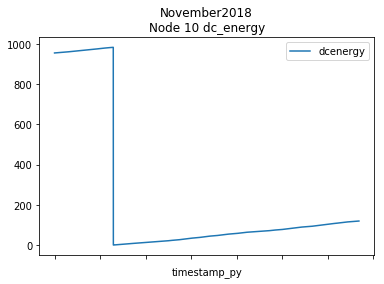

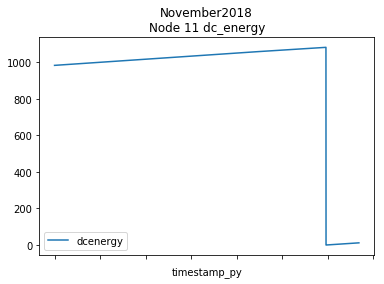

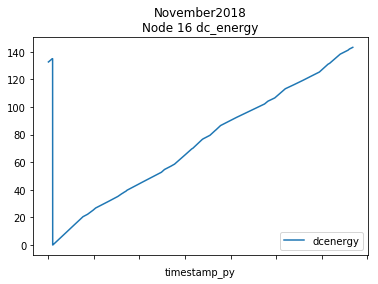

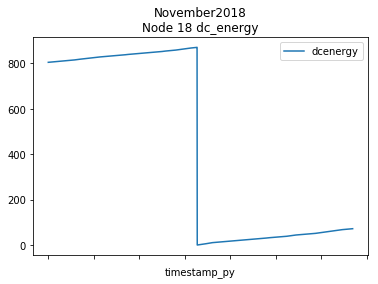

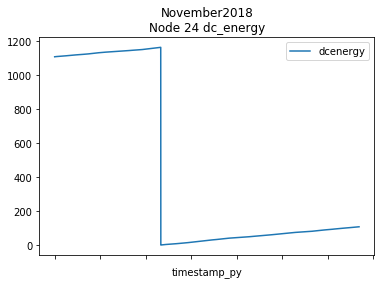

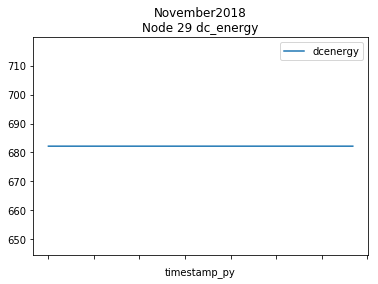

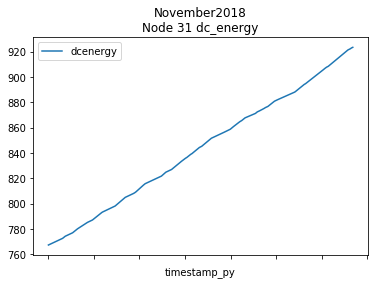

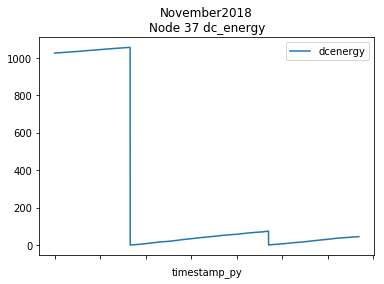

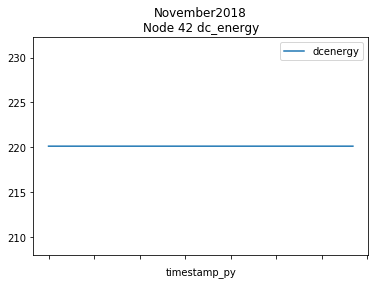

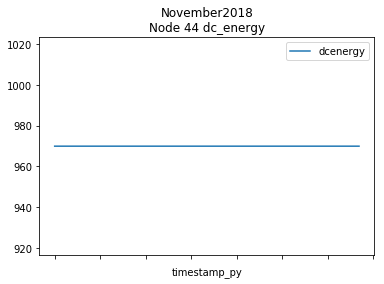

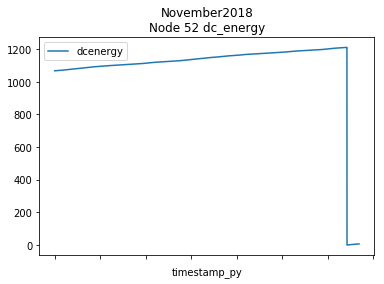

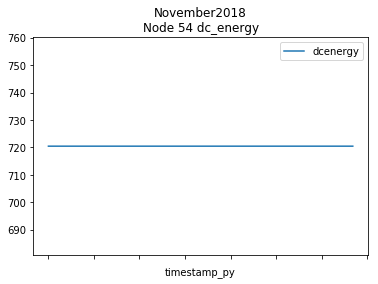

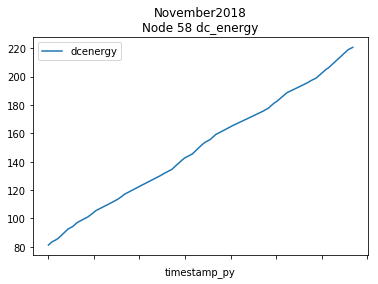

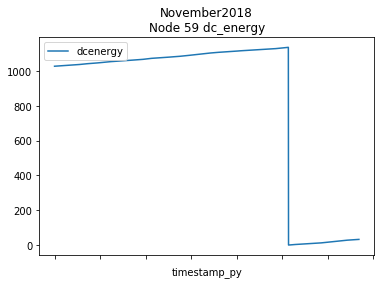

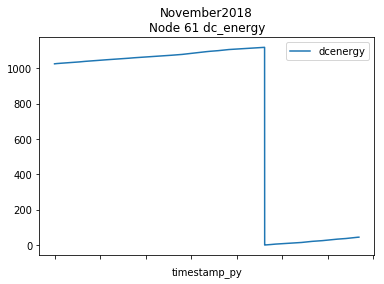

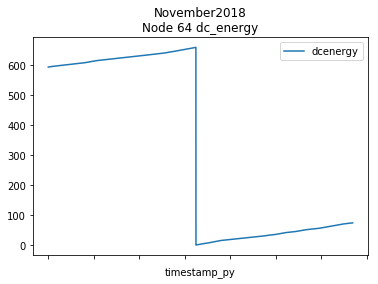

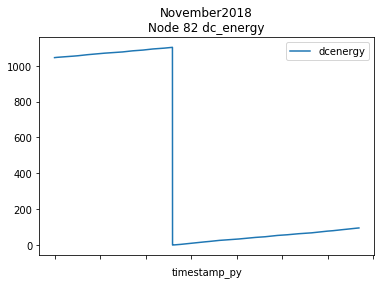

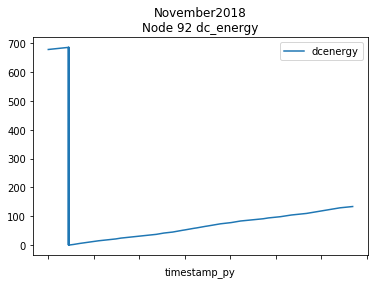

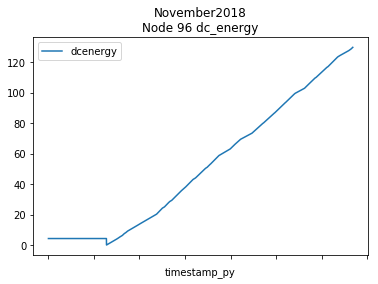

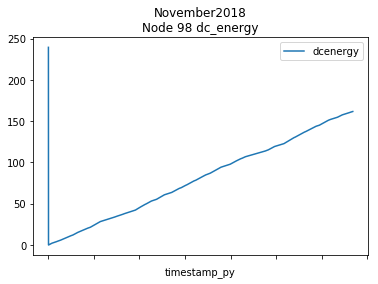

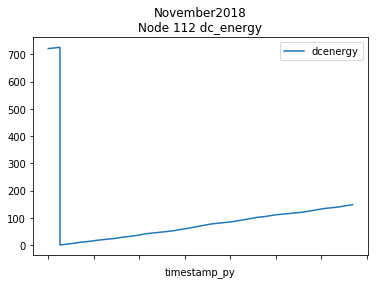

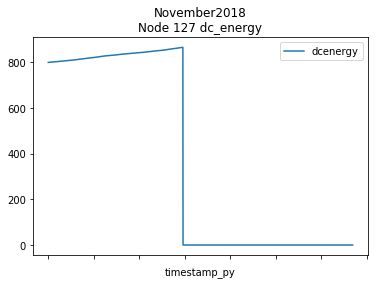

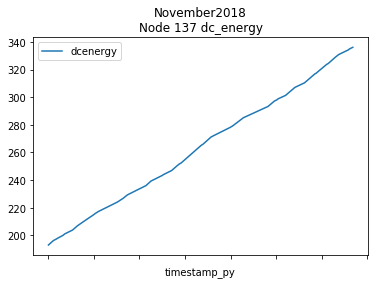

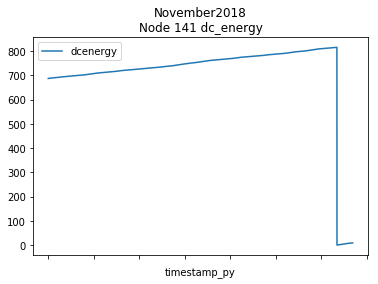

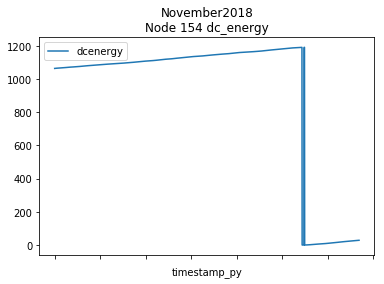

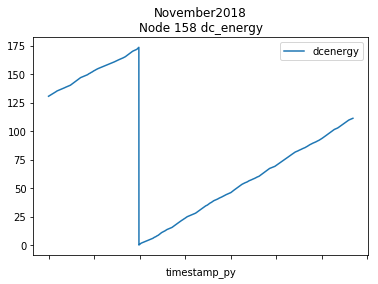

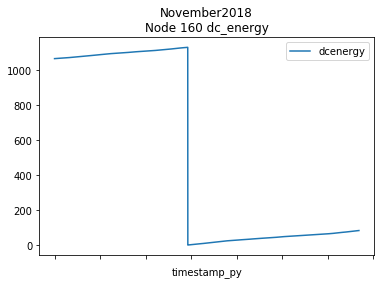

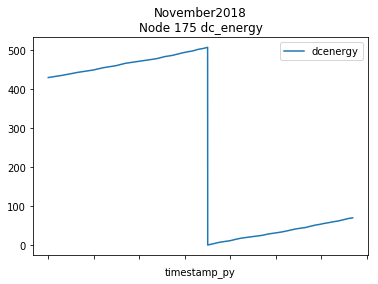

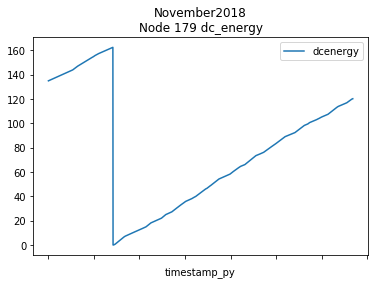

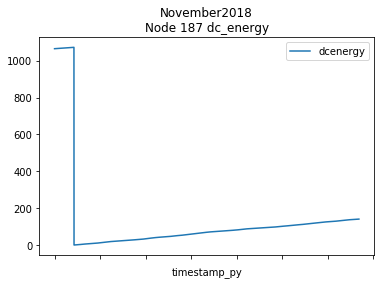

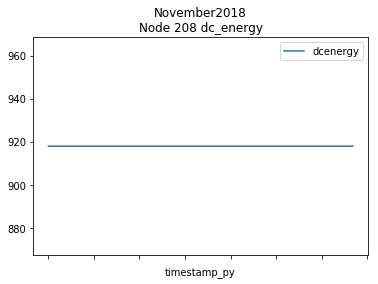

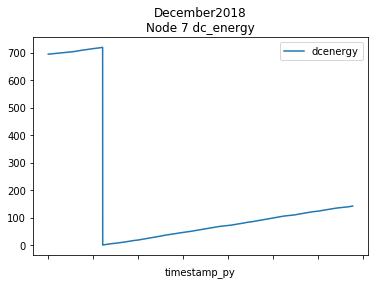

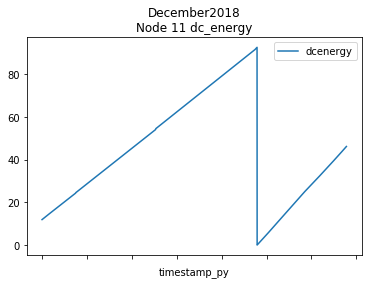

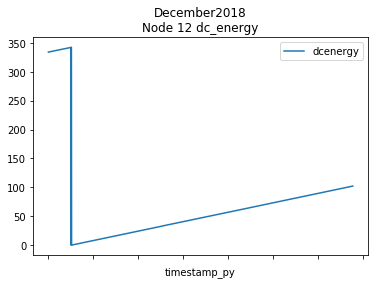

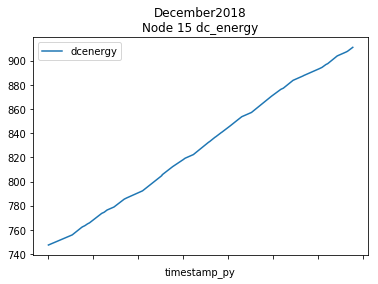

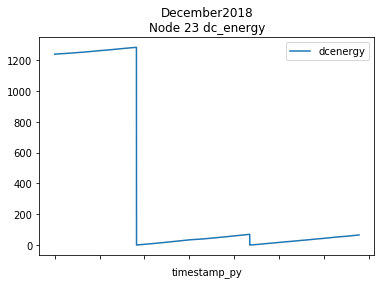

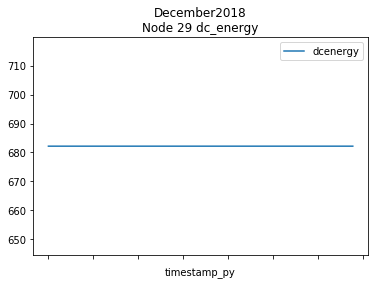

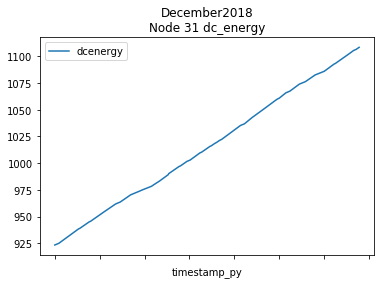

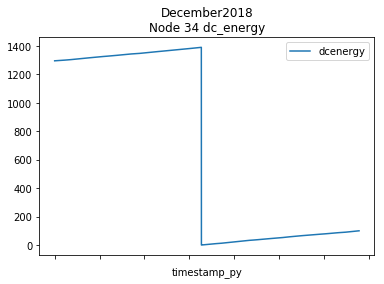

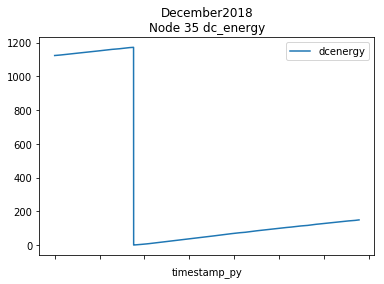

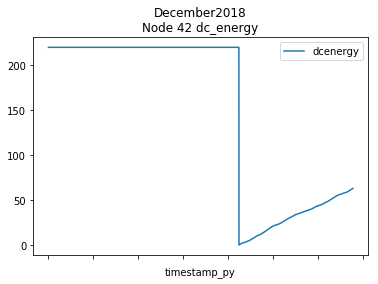

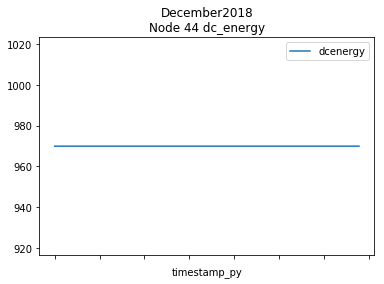

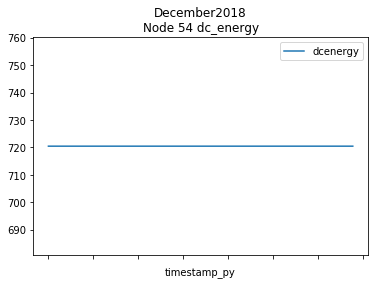

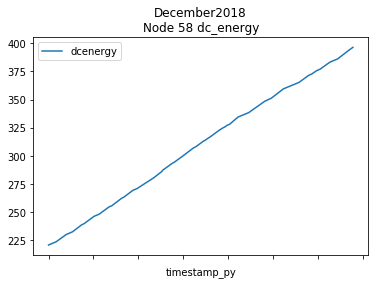

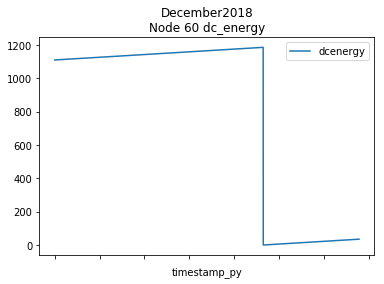

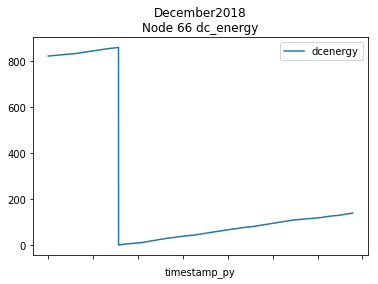

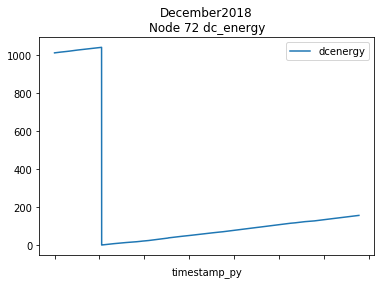

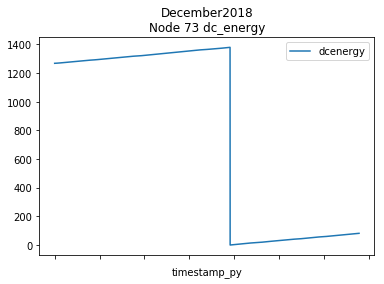

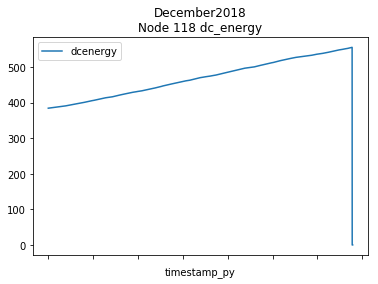

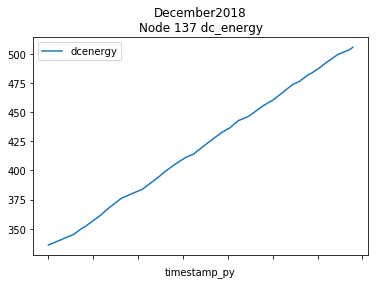

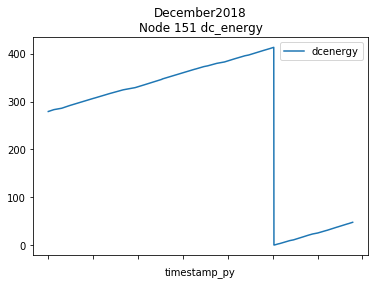

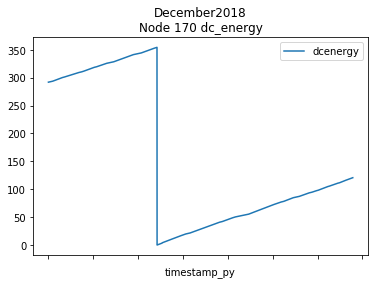

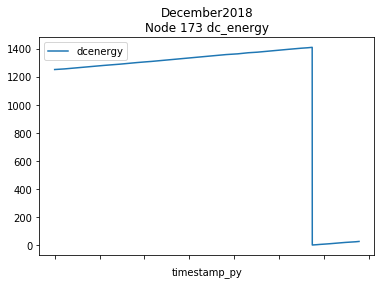

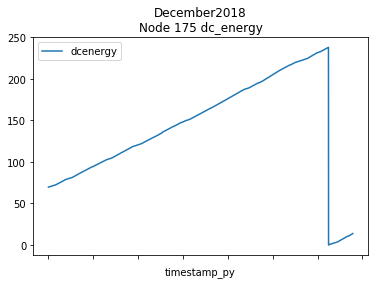

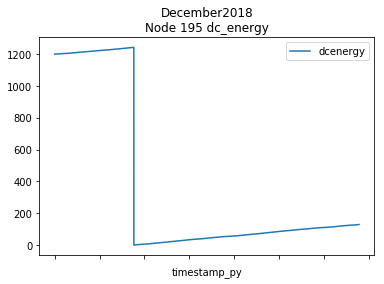

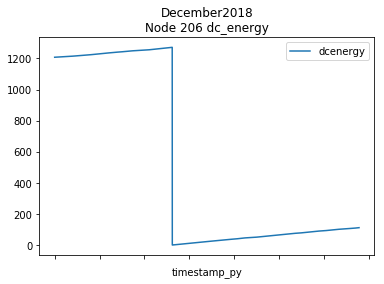

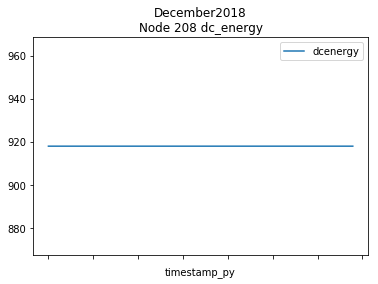

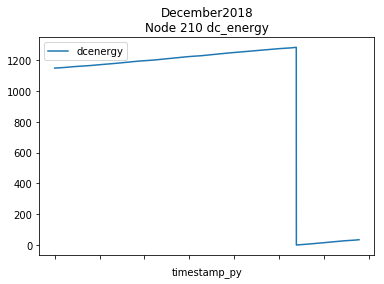

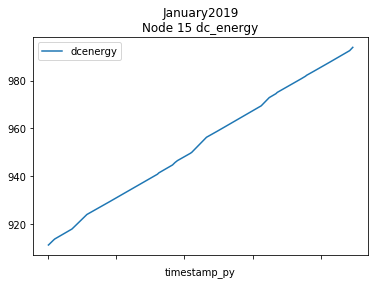

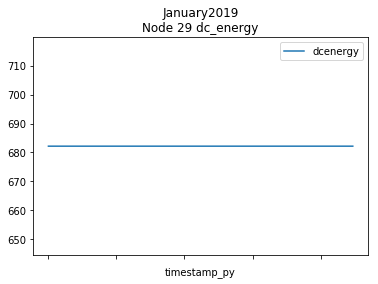

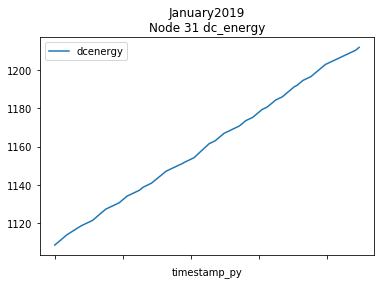

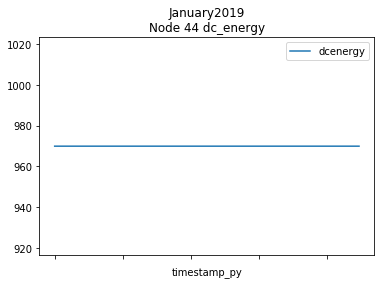

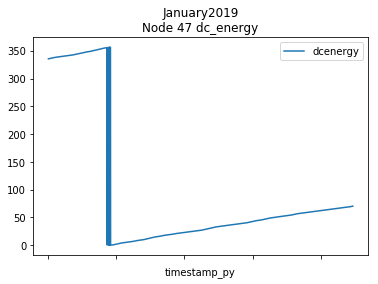

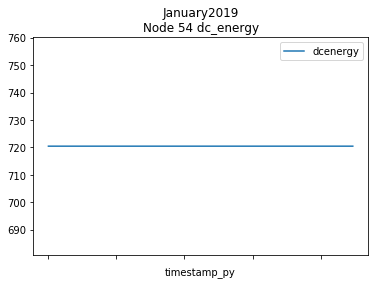

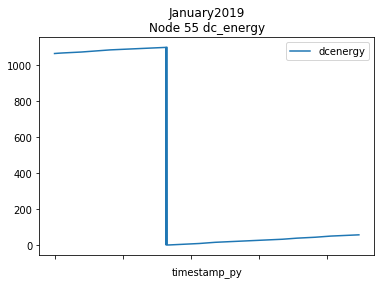

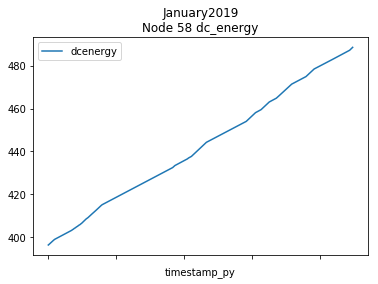

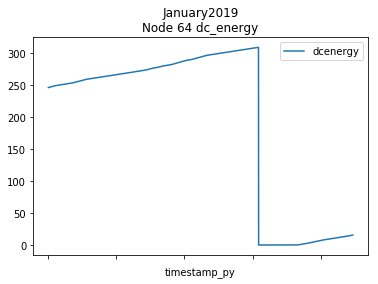

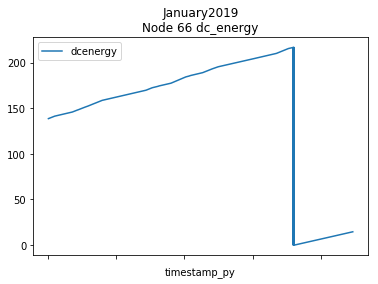

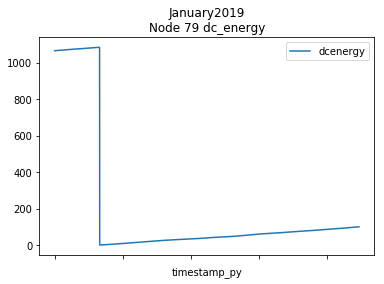

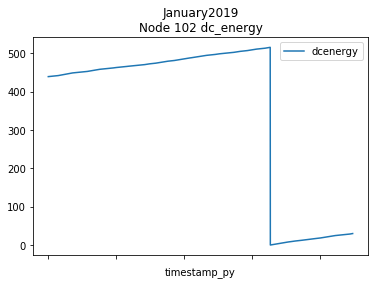

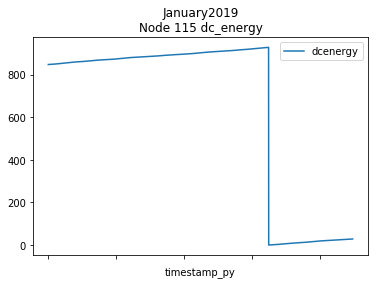

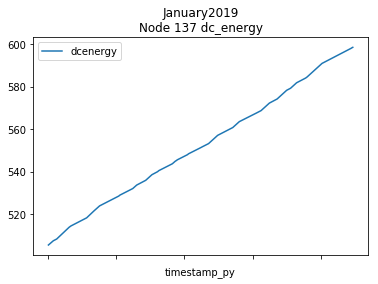

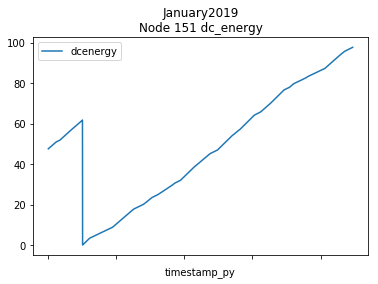

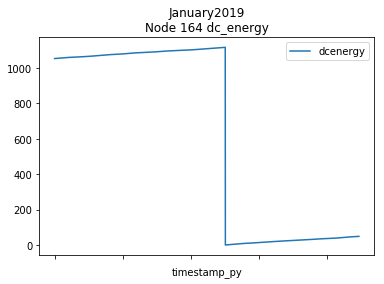

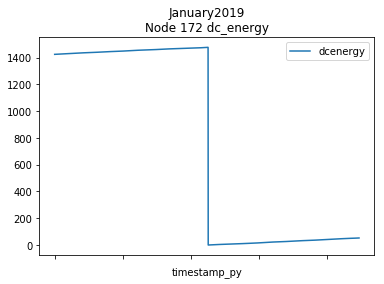

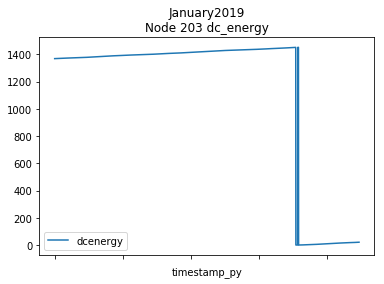

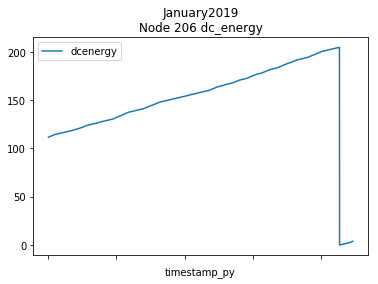

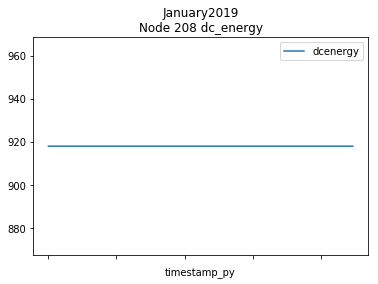

In [12]:
%matplotlib inline
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_stats = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_'+file_name), delimiter=";", header=0 )
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    for node in nodes_stats.iloc[:, dcenergy_error_nodes_dict[df_name]+1 ].columns.values:
        int_name = int(node.split('x')[-1])
        node_df[node_df.nodename == node].\
            plot(x='timestamp_py', y='dcenergy', title=df_name+'\nNode '+str(int_name)+' dc_energy')

### Max CPU, system and memory power utilization of nodes over all months

In [83]:
node_max_power = pd.DataFrame(columns = node_names, \
                              index = ['cpu_power_max', 'mem_power_max', 'sys_power_max'], \
                              data=0)
for file_name in nodes_file_names:
    nodes_stats = pd.read_csv( os.path.join( Output_dir, 'nodes_stats_'+file_name), \
                              delimiter=";", header=0, index_col=0 )
    for node in node_names:
        for util_type in ['cpu', 'mem', 'sys']:
            max_val = nodes_stats.loc[util_type + '_power_max', node]
            if node_max_power.loc[util_type + '_power_max', node] < max_val:
                node_max_power.loc[util_type + '_power_max', node] = max_val
                              

In [84]:
node_max_power.to_csv( path_or_buf=os.path.join( Output_dir, 'node_max_power_all_months.csv'), sep=';') 

In [85]:
node_max_power = pd.read_csv( os.path.join( Output_dir, 'node_max_power_all_months.csv'), \
                              delimiter=";", header=0, index_col=0 )
node_max_power

,cresco6x001,cresco6x002,cresco6x003,cresco6x004,cresco6x005,cresco6x006,cresco6x007,cresco6x008,cresco6x009,cresco6x010,...,cresco6x207,cresco6x208,cresco6x209,cresco6x210,cresco6x211,cresco6x212,cresco6x213,cresco6x214,cresco6x215,cresco6x216
cpu_power_max,270.0,290.0,290.0,320.0,280.0,340.0,340.0,340.0,340.0,350.0,...,350.0,340.0,340.0,340.0,340.0,350.0,340.0,340.0,270.0,250.0
mem_power_max,44.0,44.0,43.0,42.0,44.0,44.0,44.0,45.0,41.0,44.0,...,45.0,45.0,43.0,46.0,42.0,44.0,47.0,42.0,18.0,27.0
sys_power_max,350.0,360.0,360.0,360.0,340.0,430.0,430.0,430.0,440.0,430.0,...,440.0,440.0,440.0,440.0,430.0,440.0,440.0,430.0,320.0,300.0


In [14]:
print('Max system power use observed: \t', node_max_power.loc['sys_power_max',:].max(), \
      '\nMax CPU power use observed: \t', node_max_power.loc['cpu_power_max',:].max(), \
      '\nMax memory power use observed: \t', node_max_power.loc['mem_power_max',:].max())

Max system power use observed: 	 450.0 
Max CPU power use observed: 	 350.0 
Max memory power use observed: 	 255.0


### Energy consumption of CPU, memory and other components for all months

In [5]:
# Create a dictionary with months as keys 
# including information about every node,
# where nodes with missing data are skipped.
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_' + file_name), \
                                         delimiter=";", header=0, index_col=0)
    to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :] > 5.)[0]))
    to_drop = nodes_df_dict[df_name].iloc[:,to_drop_ix].columns.values
    nodes_df_dict[df_name].drop(columns=to_drop, inplace=True)

In [11]:
# Create a dictionary with months as keys 
# including information averaged for all the nodes
nodes_energy_summary_dict = {}

for df_name in nodes_df_names:
    nodes_energy_summary_dict[df_name] = nodes_df_dict[df_name].iloc[:12,:].mean(axis=1)

In [18]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter( os.path.join( Output_dir, 'nodes_energy_summary_dict.xlsx'), engine='xlsxwriter')

# Write each dataframe to a different worksheet.
for df_name in nodes_df_names:
    nodes_energy_summary_dict[df_name].to_excel(writer, sheet_name=df_name, header=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

## Temperature, fans speed and CPU power trends - September

In [ ]:
for df_name in nodes_df_names:
    year = re.findall(r'\d+', df_name)[0]
    month = df_name.split(year)[0]
    plot_energy_cons(data=nodes_df_dict[df_name].iloc[5:8,:].mean(axis=1), \
                     node='', \
                     month=month, year=year, avg_flag=True)

In [24]:
nodes_stats_Sept = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_September2018.csv'), \
                                         delimiter=";", header=0, index_col=0)
to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :] > 5.)[0]))
to_drop = nodes_stats_Sept.iloc[:,to_drop_ix].columns.values
node_df_Sept = pd.read_csv(os.path.join( Data_prep_dir, 'September2018.csv'), \
                                         delimiter=";", header=0)
for node in to_drop:
    node_df_Sept.drop(index=node_df_Sept[node_df_Sept.nodename == node].index)

In [25]:
node_Sept_norm = node_df_Sept[node_df_Sept.nodename == node_df_Sept.nodename.unique()[0]].copy()

node_Sept_norm.loc[:, ['cpu_power', 'cpu1_temp', 'cpu2_temp', 'exh_temp']] = \
    preprocessing.normalize(node_Sept_norm.loc[:, ['cpu_power','cpu1_temp', 'cpu2_temp', 'exh_temp']], norm='max', axis=0)
node_Sept_norm.exh_temp = round(node_Sept_norm.exh_temp, 1)

### Spearman correlation coefficient

In [26]:
stats.spearmanr(a=node_df_Sept.exh_temp.values, b=node_df_Sept.cpu_power.values)

SpearmanrResult(correlation=0.3486975817138365, pvalue=0.0)

### Pearson correlation coefficient

In [27]:
print(stats.pearsonr(node_Sept_norm.cpu_power, node_Sept_norm.cpu1_temp), \
      stats.pearsonr(node_Sept_norm.cpu_power, node_Sept_norm.cpu2_temp), \
      stats.pearsonr(node_Sept_norm.cpu_power, node_Sept_norm.exh_temp))

(0.39054727848038256, 1.6573117150516118e-110) (0.4455773885153568, 4.1237857999012705e-147) (0.2811746778478721, 6.179197441727707e-56)


In [28]:
print(stats.pearsonr(node_Sept_norm.cpu_power, node_Sept_norm.exh_temp))

(0.2811746778478721, 6.179197441727707e-56)


## Further analysis
- normalize and correlate fans and CPU power ranges
- investigate on temperature fluctuations
- think of how to work with all the nodes